In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

In [ ]:
# Load and sort data
df = pd.read_csv('modified_dataframe.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [6]:
df.head()

,Date,Country,City,Specie,count,min,max,median,variance,year,month,season
33453,2014-12-29,CN,Xi’an,co,379,2.9,82.7,22.8,1119.71,2014,12,Winter
38595,2014-12-29,CN,Changzhou,no2,206,6.0,59.5,30.2,1385.16,2014,12,Winter
3611,2014-12-29,CN,Hangzhou,pm10,288,6.0,144.0,79.0,2514.47,2014,12,Winter
38913,2014-12-29,CN,Changzhou,co,206,5.3,500.0,17.4,322251.00,2014,12,Winter
39100,2014-12-29,CN,Nanchang,co,204,1.2,22.4,9.6,137.56,2014,12,Winter


In [7]:
# Filter PM2.5
df_pm25 = df[df['Specie'] == 'pm25'].copy()

In [ ]:
# Encode city
city_encoder = OneHotEncoder(sparse_output=False)
city_encoded = city_encoder.fit_transform(df_pm25[['City']])
city_encoded_df = pd.DataFrame(city_encoded, index=df_pm25.index, columns=city_encoder.get_feature_names_out(['City']))

# Encode season
season_encoded = pd.get_dummies(df_pm25['season'], prefix='season')

In [9]:
# Combine features
features = df_pm25[['median', 'year', 'month']].join([city_encoded_df, season_encoded])

# Normalize numeric features
scaler = MinMaxScaler()
features[['median', 'year', 'month']] = scaler.fit_transform(features[['median', 'year', 'month']])

# Store scaler for inverse transformation
pm25_scaler = MinMaxScaler()
features['median'] = pm25_scaler.fit_transform(df_pm25[['median']])

In [ ]:
# Sequence creation
time_step = 60
dataset = features.values
x_data, y_data = [], []

for i in range(time_step, len(dataset)):
    x_data.append(dataset[i-time_step:i])
    y_data.append(dataset[i, 0])  # median PM2.5

In [11]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split
train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [12]:
# Ensure x_train, x_test, y_train, y_test are float32 numpy arrays
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [13]:
# Build model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_step, x_data.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)
]

In [16]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (123213, 60, 59)
y_train shape: (123213,)


In [ ]:
# Train
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - loss: 0.0040 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 2/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 0.0035 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 3/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.0035 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0034 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 6/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.0034 - val_loss: 0.0038 - learning_rate: 5.0000e-04
Epoch 9/10
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0033 - val_loss: 0

In [ ]:
# Predict
predictions = model.predict(x_test).flatten()
predictions = pm25_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_inv = pm25_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

963/963 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [19]:
# Metrics
mse = mean_squared_error(y_test_inv, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions)
r2 = r2_score(y_test_inv, predictions)

In [ ]:
print("\nModel Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


✅ Improved Model Performance:
MSE: 1114.51
RMSE: 33.38
MAE: 25.57
R²: 0.32


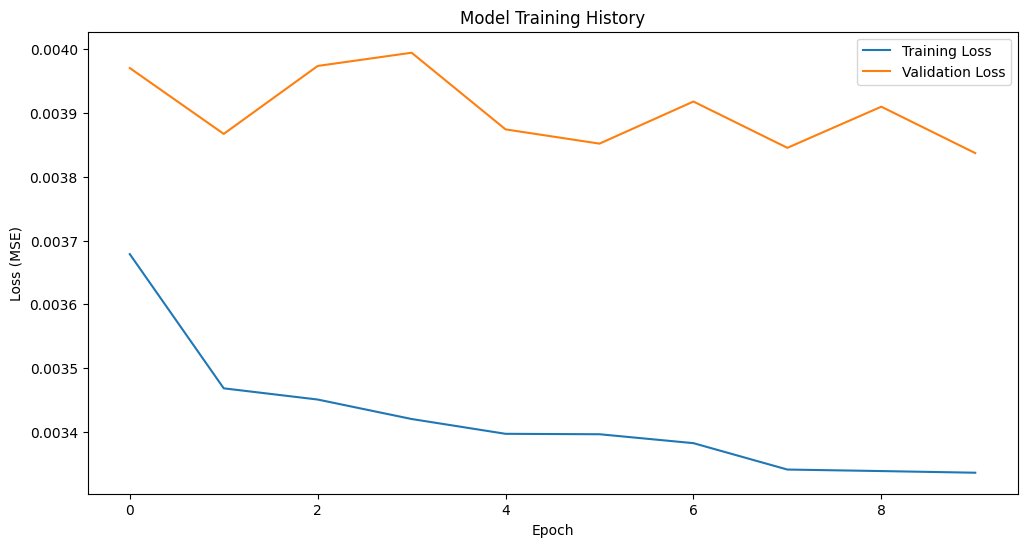

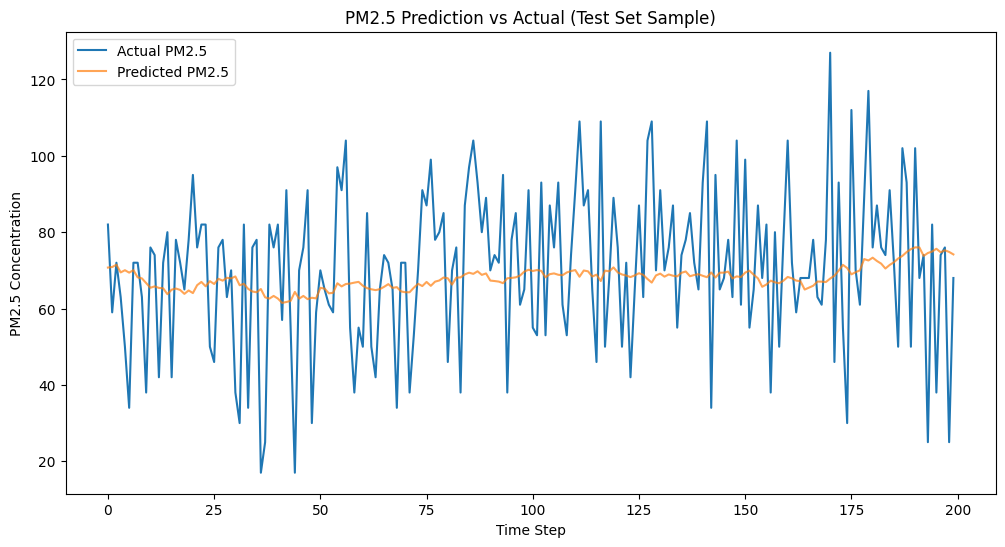

In [21]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot predictions vs actual values for a sample of the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label='Actual PM2.5')
plt.plot(predictions[:200], label='Predicted PM2.5', alpha=0.7)
plt.title('PM2.5 Prediction vs Actual (Test Set Sample)')
plt.ylabel('PM2.5 Concentration')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [ ]:
# Save the crucial components for our web app
model.save('unified_lstm_model.h5')
model.save('unified_lstm_model.keras')
joblib.dump(pm25_scaler, 'unified_pm25_scaler.pkl')
joblib.dump(city_encoder, 'city_encoder.pkl') # We need the city encoder
joblib.dump(scaler, "full_feature_scaler.pkl")

print("Unified model and necessary encoders have been saved.")

Unified model and necessary encoders have been saved.
